<a href="https://colab.research.google.com/github/sameer-nema/Data-Analysis-Internship/blob/main/skin_cancer_image_customCNN1_%26_mobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math 
import shutil 
import glob 
from keras.preprocessing.image import load_img, img_to_array

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential 

from keras.applications.mobilenet import MobileNet

from keras.models import load_model
from keras.models import Model
import keras

from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_DIR = "/content/drive/MyDrive/skin_cancer_dataset/Complete_data_unsplit_benign_&_malignant"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))
    
number_of_images.items()
os.listdir("/content/drive/MyDrive/skin_cancer_dataset/Complete_data_unsplit_benign_&_malignant")

['malignant', 'benign']

# DATASET SPLIT 
let's perform a split 70% for training 15% for validation and 15% for testing



In [ ]:
def dataFolderSplit(path, split):
    
    if not os.path.exists("./"+path):
        os.mkdir("./"+path)
    
        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+path+"/"+dir)
            for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), 
                                        size = (math.floor(split*number_of_images[dir])-5), 
                                        replace=False):

                OG = os.path.join(ROOT_DIR, dir, img) 
                DEST = os.path.join("./"+path,dir)
                shutil.copy(OG, DEST) #tr
                os.remove(OG)
        
    else:
        print(f"{path} folder already exists")

In [ ]:
# for train split
dataFolderSplit("train", 0.7)

# for validation split
dataFolderSplit("val", 0.15)

# for test split
dataFolderSplit("test", 0.15)

# DATA PREPROCESSING 

In [ ]:
def preprocessingImages1(path):
    '''
    input: path
    output: pre processed images
    '''
    image_data = ImageDataGenerator(zoom_range=0.2, 
                                    shear_range=0.2, 
                                    rescale=1/255, 
                                    horizontal_flip=True) # data augmentation
    image = image_data.flow_from_directory(directory=path, target_size=(224,224), 
                                           batch_size=32) 
    return image

# for validation and testing i want the data to be generalized and natural 
# removed augmentation
def preprocessingImages2(path):
    '''
    input: path
    output: pre processed images
    '''
    image_data = ImageDataGenerator(rescale = 1/255)
    image = image_data.flow_from_directory(directory=path, 
                                           target_size=(224,224), 
                                           batch_size=32) 
    return image

In [ ]:
# train data preprocessing
path = "/content/drive/MyDrive/skin_cancer_dataset/train"
train_data = preprocessingImages1(path)

Found 2297 images belonging to 2 classes.


In [ ]:
# vaidation data preprocessing
path = "/content/drive/MyDrive/skin_cancer_dataset/val"
val_data = preprocessingImages2(path)

Found 484 images belonging to 2 classes.


In [ ]:
# test data preprocessing
path = "/content/drive/MyDrive/skin_cancer_dataset/test"
test_data = preprocessingImages2(path)

Found 484 images belonging to 2 classes.


# MODEL BUILDING

Custom CNN - model1

In [ ]:
model1 = Sequential()

model1.add(Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(3,3), activation='relu'))

model1.add(Conv2D(filters=36, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Dropout(rate=0.25))

model1.add(Flatten())
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(rate=0.25))
model1.add(Dense(units=2, activation='sigmoid')) 

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

MobileNet - model2

In [ ]:
base_model = MobileNet(input_shape=(224,224,3), include_top=False)
# we don't want to pretrain the layers of the model again 
for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
X = Flatten()(base_model.output) # input for flatten is last layer's output
X = Dense(units = 2, activation = 'sigmoid')(X) # input for dense is X

model2 = Model(base_model.input, X)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

# MODEL COMPILATION


Custom CNN

In [ ]:
model1.compile(optimizer='adam', 
              loss=keras.losses.binary_crossentropy, 
              metrics=['accuracy'])

MobileNet

In [ ]:
model2.compile(optimizer='adam', 
              loss=keras.losses.binary_crossentropy, 
              metrics=['accuracy'])

# CALLBACKS

Custom CNN - model1

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# EARLY STOPPING
es1 = EarlyStopping(monitor="val_accuracy", 
                   min_delta=0.01, 
                   patience=5, 
                   verbose=1, 
                   mode='auto')

# MODEL CHECKPOINT
mcp1 = ModelCheckpoint(monitor="val_accuracy", 
                      filepath="/content/drive/MyDrive/skin_cancer_dataset/bestmodel.h5", 
                      verbose=1, 
                      save_best_only=True, 
                      mode='auto') 

# to pass them in our model we need them in array format
cb1 = [es1, mcp1]

MobileNet - model2

In [ ]:
#callbacks
mcp2 = ModelCheckpoint(filepath="/content/drive/MyDrive/skin_cancer_dataset/bestmodel_moNet.h5",
                      monitor='val_accuracy', 
                      verbose=1, 
                      save_best_model_only=True,
                      mode='auto')

es2 = EarlyStopping(monitor='val_accuracy', 
                   min_delta=0.01, 
                   patience=5, 
                   verbose=1, 
                   mode='auto')

cb2 = [mcp2, es2]

# MODEL TRAINING

In [ ]:
history1 = model1.fit(train_data, 
                      steps_per_epoch=8, 
                      epochs=30, 
                      verbose=1, 
                      validation_data=val_data, 
                      validation_steps=16, 
                      callbacks=cb1)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5743
Epoch 1: val_accuracy did not improve from 0.76240
8/8 [==============================] - 68s 8s/step - loss: 0.6864 - accuracy: 0.5743 - val_loss: 0.6714 - val_accuracy: 0.5475
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.6289
Epoch 2: val_accuracy did not improve from 0.76240
8/8 [==============================] - 65s 8s/step - loss: 0.6307 - accuracy: 0.6289 - val_loss: 0.6170 - val_accuracy: 0.5496
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.5742
Epoch 3: val_accuracy did not improve from 0.76240
8/8 [==============================] - 68s 8s/step - loss: 0.6460 - accuracy: 0.5742 - val_loss: 0.6374 - val_accuracy: 0.5744
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.6367
Epoch 4: val_accuracy did not improve from 0.76240
8/8 [==============================] - 66s 8s/s

In [ ]:
history_moNet = model2.fit(train_data, 
                  steps_per_epoch=10, 
                  epochs=30,
                  verbose=1, 
                  validation_data=val_data, 
                  validation_steps=16,
                  callbacks=cb2)

# MODEL VISUALIZATION


Custom CNN

In [ ]:
h1 = history1.history
h1.keys()

NameError: ignored

Text(0.5, 1.0, 'Accuracy vs Validation Accuracy')

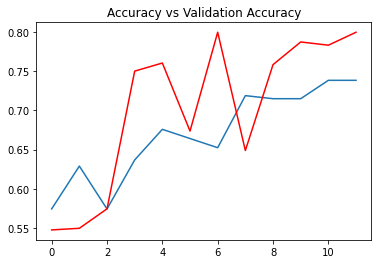

In [ ]:
plt.plot(h1['accuracy'])
plt.plot(h1['val_accuracy'], c="red")

plt.title("Accuracy vs Validation Accuracy")

Text(0.5, 1.0, 'Loss vs Validation Loss')

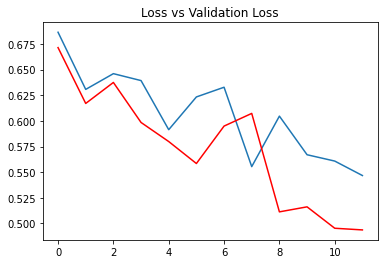

In [ ]:
plt.plot(h1['loss'])
plt.plot(h1['val_loss'], c="red")

plt.title("Loss vs Validation Loss")

MobileNet

In [ ]:
h_moNet = history_moNet.history
h_moNet.keys()

In [ ]:
plt.plot(h_moNet['accuracy'])
plt.plot(h_moNet['val_accuracy'], c="red")

plt.title("Accuracy vs Validation Accuracy")

# MODEL PERFORMANCE ANALYSIS


Custom CNN

In [ ]:
# we'll load our best model
model_1 = load_model("/content/drive/MyDrive/skin_cancer_dataset/bestmodel.h5")

accuracy_1 = model_1.evaluate(test_data)[1]
# since, 0th = loss, 1th = accuracy
print(f"The accuracy of of our model is {accuracy_1*100} %")

16/16 [==============================] - 61s 4s/step - loss: 0.6158 - accuracy: 0.7252
The accuracy of of our model is 72.52066135406494 %


[[1. 0.]]
Benign


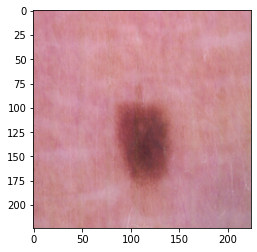

In [ ]:
# Predicting any Random Skin cancer Image
path = "/content/drive/MyDrive/skin_cancer_dataset/Complete_data_unsplit_benign_&_malignant/benign/427.jpg"
img = load_img(path,target_size=(224,224))

# Converted the image into numpy array
img = np.asarray(img)
plt.imshow(img)

# Added an Extra Dimension to image for matching Number, Height, Width, Channel (NHWC) format of Keras
img = np.expand_dims(img, axis=0)
output = model_1.predict(img)
print(output)

if output[0][0] > output[0][1]:
  print("Benign")
else:
  print("Malignant")

MobileNet

In [ ]:
# we'll load our best model
model_mobilenet = load_model("/content/drive/MyDrive/skin_cancer_dataset/bestmodel_moNet.h5")

accuracy_mobilenet = model_mobilenet.evaluate(test_data)[1]
# since, 0th = loss, 1th = accuracy
print(f"The accuracy of of our model is {accuracy_mobilenet*100} %")

16/16 [==============================] - 18s 1s/step - loss: 0.9862 - accuracy: 0.7789
The accuracy of of our model is 77.89255976676941 %


[[9.999980e-01 6.892902e-06]]
Benign


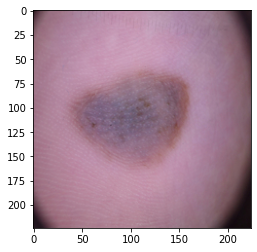

In [ ]:
# Predicting any Random Skin cancer Image
path = "/content/drive/MyDrive/skin_cancer_dataset/Complete_data_unsplit_benign_&_malignant/benign/951.jpg"
img = load_img(path,target_size=(224,224))

# Converted the image into numpy array
img = np.asarray(img)
plt.imshow(img)

# Added an Extra Dimension to image for matching Number, Height, Width, Channel (NHWC) format of Keras
img = np.expand_dims(img, axis=0)
output = model_mobilenet.predict(img)
print(output)

if output[0][0] > output[0][1]:
  print("Benign")
else:
  print("Malignant")

# Confusion Matrix and Classificaton Report

In [ ]:
val_data.classes

Custom CNN

In [ ]:
Y_pred1 = model_1.predict(val_data)
y_pred1 = np.argmax(Y_pred1, axis=1)

print('Confusion Matrix:')
cm = confusion_matrix(val_data.classes, y_pred1)
target_names = ['benign', 'malignant']
print(cm)
# plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
print()

print('Classification Report:')
print(classification_report(val_data.classes, y_pred1, target_names=target_names))

Confusion Matrix:
[[103 162]
 [ 79 140]]

Classification Report:
              precision    recall  f1-score   support

      benign       0.57      0.39      0.46       265
   malignant       0.46      0.64      0.54       219

    accuracy                           0.50       484
   macro avg       0.51      0.51      0.50       484
weighted avg       0.52      0.50      0.50       484



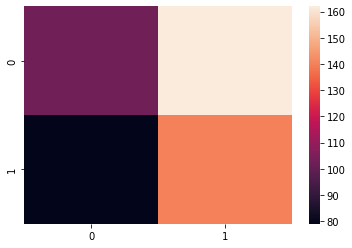

In [ ]:
import seaborn as sns
sns.heatmap(cm)

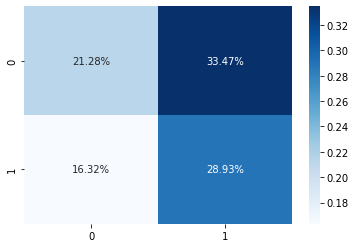

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
# percentage of data is represented in each quadrant

MobileNet

In [ ]:
Y_pred2 = model_mobilenet.predict(val_data)
y_pred2 = np.argmax(Y_pred2, axis=1)

print('Confusion Matrix:')
cm = confusion_matrix(val_data.classes, y_pred2)
target_names = ['benign', 'malignant']
print(cm)
# plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
print()

print('Classification Report:')
print(classification_report(val_data.classes, y_pred2
                            , target_names=target_names))

Confusion Matrix:
[[200  65]
 [167  52]]

Classification Report:
              precision    recall  f1-score   support

      benign       0.54      0.75      0.63       265
   malignant       0.44      0.24      0.31       219

    accuracy                           0.52       484
   macro avg       0.49      0.50      0.47       484
weighted avg       0.50      0.52      0.49       484

